# UH vs. SRH Fluctuations and Prior-Time UH

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 21

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import datetime
import haversine
import scipy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import centered_response as cr
from wofunits import wofunits

# suppress warnings given loops with them
import warnings
warnings.filterwarnings("ignore")

## Manually set time, inflow domain specs, etc. for the desired plotting

In [4]:
# Case list
cases = ['201905172200', '201905202030', '201905262000', '201905282230']

# state and response variables
statevar = 'SRH3-TRUE'
respvar = 'UH25-05MIN'

# thresholding specs
pthres = 0.05 # max p-value 
ang_thres = 60 # angular threshold on either side of storm motion vector
nf_dist = 40 # distance bound of near-inflow domain
ang_bound1, ang_bound2 = 120, 240 # angular domain bounds relative to the storm motion

# plotting specs
colors = ['red','limegreen','orange','blue'] # scatter colors per case
axlabels = ['a)','b)'] # axis labels
ypos = [0.90,0.84,0.78,0.72] # y-coordinate positions for stats text

# save figure?
save = True

# Set paths
sens_path = wofunits.paths['sens_path']
resp_path = wofunits.paths['resp_path']
sm_path = wofunits.paths['sm_path']
outplot_path = wofunits.paths['outplot_path']

## Plot Fig. 21: Time-Lagged UH vs. SRH03 Changes and Prior-Time UH 
### (To Diagnose Autocorrelative Influence)

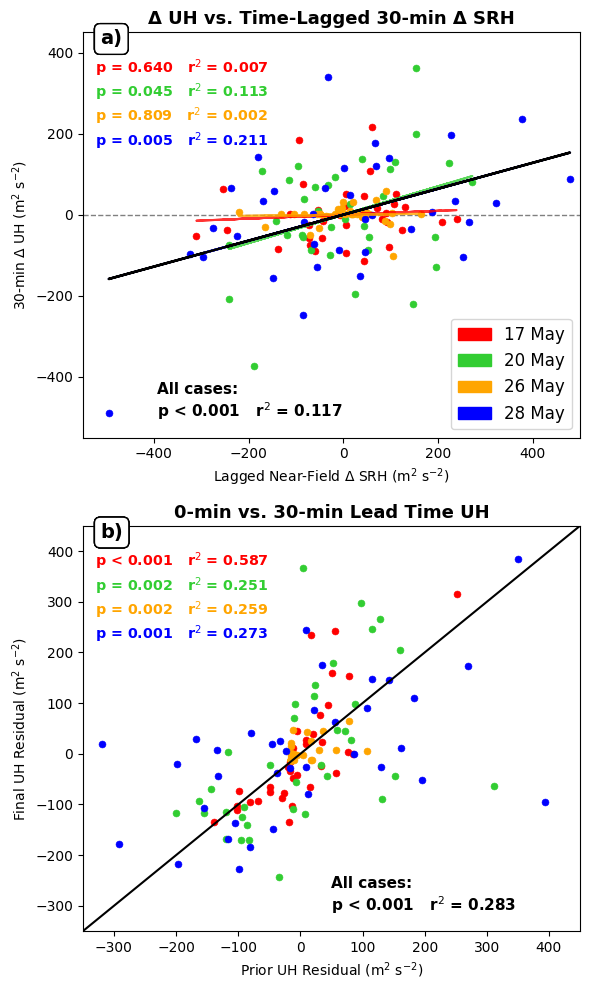

In [5]:
#%%capture

fig, ax = plt.subplots(2,1,figsize=(6,10))
ax = ax.flatten()

for j in range(2):
    
    srh_diffs, resp_diffs = [],[]
    resp_00s, resp_30s = [],[]
    resp_00_norms, resp_30_norms = [],[]
    srh_30s = []
    srh_30_fields=[]
    xmeshs, ymeshs=[],[]
    for k, case in enumerate(cases):
        
        # Define case specs
        wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)
        
        df = cr.create_coords_df(file_resp_coords, file_mrms_maxima) # 5-min response interval
        
        ######## Define case specs ###########
        
            # define state and response time as datetime objects
        resp_time = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
        
        state_time_15 = resp_time - datetime.timedelta(minutes=15)
        state_time_30 = resp_time - datetime.timedelta(minutes=30)
        state_time_45 = resp_time - datetime.timedelta(minutes=45)
        
        statetimelist = [resp_time, state_time_15, state_time_30, state_time_45]
        #pstat = ds_sens.pstat.values
        
        ################################ Define storm-relative aspects  #######################################
        
        files_sens, dists,storm_angs,ang_tots,ang_diffs = [],[],[],[],[]
        
        for state_time in statetimelist:
            
            file_sens = f'{sens_path}/sens_center_{case}/stats_{respvar}_max_{str(resp_time.hour).zfill(2)}_{str(resp_time.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
            
                # define observed MRMS storm centers to center storm on plot
            df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
            
                # string to 
            pdstr = f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'
            
                    # open storm motion csv files
            sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
            sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')
            
                # average storm motion components at chosen time
            sm_mean_x = np.nanmean(sm_x[:-1][pdstr].values)
            sm_mean_y = np.nanmean(sm_y[:-1][pdstr].values)
            
                # calculate angle of storm motion relative to positive x-axis
            storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)
            
                # create 2D x and y storm-relative grids
            xmesh,ymesh = cr.xy_mesh(case, state_time)
            dist = (xmesh**2 + ymesh**2)**0.5 # convert to 2D meshgrid
            
                # calculate storm-relative angle of each gridpoint 
            ang_tot = cr.calc_ang_tot(xmesh,ymesh,storm_ang=storm_ang)
            
                # calculate angle difference between SR gridpoint position and SR 
            ang_diff = cr.srw_ang_diff(case, state_time)
            
            files_sens.append(file_sens)
            dists.append(dist)
            storm_angs.append(storm_ang)
            ang_tots.append(ang_tot)
            ang_diffs.append(ang_diff)
        
        files_sens = np.array(files_sens)
        dists = np.array(dists)
        storm_angs = np.array(storm_angs)
        ang_tots = np.array(ang_tots)
        ang_diffs = np.array(ang_diffs)
        xmeshs.append(xmesh), ymeshs.append(ymesh)
        
        ################ Pull UH magnitude of storm-centered mesocyclone #############################
        
        
        files = files_wofs
        
        uhmax_time, wzmax_time, wmax_time, time = [],[],[],[]
        for i, (nycol, nxcol) in enumerate(zip(df.columns[0::2], df.columns[1::2])):
        
            ds = xr.open_dataset(files[i])
            
            uh_max, wz_max, w_max = [],[],[]
            
            for mem in range(36):
            
                center_ny = df[nycol].values[mem]
                center_nx = df[nxcol].values[mem]
        
                if center_ny < 0:
                    uh_max.append(0.0)
                    wz_max.append(0.0)
                    w_max.append(0.0)
                    continue
                
                max_uh = float(ds['UP_HELI_MAX'][mem,0,center_ny,center_nx].values)
            
                max_wz = float(np.nanmax(ds['WZ_25'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
                
                max_w = float(np.nanmax(ds['W_UP_MAX'][mem,0,center_ny-2:center_ny+3,center_nx-2:center_nx+3]))
                
                uh_max.append(max_uh)
                wz_max.append(max_wz)
                w_max.append(max_w)
        
            uhmax_time.append(uh_max)
            wzmax_time.append(wz_max)
            wmax_time.append(w_max)
            time.append(nxcol[:8])
        
        uhmax_arr = np.array(uhmax_time)
        
        
        ################ Process sensitivity and WoFS files #############################
        
        
            # define SR WoFS files
        files_wofs_center = [file[:60] + 'center_' + file[60:] for file in files_wofs]
        
            # define UH at lead times
        resp_00 = uhmax_arr[-1]
        resp_30 = uhmax_arr[-7]
        #resp_60 = uhmax_arr[-13]

        resp_00 = resp_00 - np.nanmean(resp_00)
        resp_30 = resp_30 - np.nanmean(resp_30)

        resp_00_norm = resp_00 / np.nanmax(np.abs(resp_00))
        resp_30_norm = resp_30 / np.nanmax(np.abs(resp_30))
        
            # define sensitivtiy datasets
        ds_sens_15 = xr.open_dataset(files_sens[1])
        ds_sens_30 = xr.open_dataset(files_sens[2])
        ds_sens_45 = xr.open_dataset(files_sens[3])
        #ds_sens_60 = xr.open_dataset(files_sens[2])
        
            # define SR WoFS datasets
        ds_wofs_15 = xr.open_dataset(files_wofs_center[-4])
        ds_wofs_30 = xr.open_dataset(files_wofs_center[-7])
        ds_wofs_45 = xr.open_dataset(files_wofs_center[-10])
        #ds_wofs_60 = xr.open_dataset(files_wofs_center[-13])
        
            # define pstat variables
        pstat_15 = ds_sens_15.pstat.values
        pstat_30 = ds_sens_30.pstat.values
        pstat_45 = ds_sens_45.pstat.values
        #pstat_60 = ds_sens_60.pstat.values
        
            # define SRH variables
        srh_15 = ds_wofs_15['SRH3_TRUE'].values
        srh_30 = ds_wofs_30['SRH3_TRUE'].values
        srh_45 = ds_wofs_45['SRH3_TRUE'].values
        #srh_60 = ds_wofs_60['SRH3_TRUE'].values

        srh_30 = srh_30# - np.nanmean(srh_30, axis=(0,1))
        srh_15 = srh_15# - np.nanmean(srh_15, axis=(0,1))
        srh_45 = srh_45# - np.nanmean(srh_45, axis=(0,1))
        
        
            # define UH time deltas
        respdiff_0m30 = resp_00 - resp_30 # / np.nanmean()
        
        #respdiff_30m60 = resp_60 - resp_30
        #respdiff_0m60 = resp_60 - resp_00
    
            # take mean near-inflow SRH(ang_tot > ang_bound1) & (ang_tot < ang_bound2), np.nan, srh_45)
        srh_15_mean = np.nanmean(np.where( (dists[1] > nf_dist) | (ang_tots[1] > ang_bound1) & (ang_tots[1] < ang_bound2) | (pstat_15 > pthres) | (pstat_15 < 0), np.nan, srh_15), axis=(1,2,3))
        srh_30_mean = np.nanmean(np.where( (dists[2] > nf_dist) | (ang_tots[2] > ang_bound1) & (ang_tots[2] < ang_bound2) | (pstat_30 > pthres) | (pstat_30 < 0), np.nan, srh_30), axis=(1,2,3))        
        srh_45_mean = np.nanmean(np.where( (dists[3] > nf_dist) | (ang_tots[3] > ang_bound1) & (ang_tots[3] < ang_bound2) | (pstat_45 > pthres) | (pstat_45 < 0), np.nan, srh_45), axis=(1,2,3))
        
        #srh_60_mean = np.nanmean(np.where( (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres | (pstat_60 > pthres) | np.isnan(pstat_60)), np.nan, srh_60), axis=(1,2,3))
        
            # take near-inflow SRH change over time
        srh_diff = ( srh_15_mean - srh_45_mean ) - np.nanmean(srh_15_mean - srh_45_mean)
        
            # collect all cases in one list
        srh_diffs.append(srh_diff)
        resp_diffs.append(respdiff_0m30)
        
        resp_00s.append(resp_00)
        resp_30s.append(resp_30)
        srh_30s.append(srh_30_mean)
        srh_30_fields.append(srh_30)
        resp_30_norms.append(resp_30_norm), resp_00_norms.append(resp_00_norm)
        ################## Calculate stats ##############################
        
        #m, b, r, p, std_err = scipy.stats.linregress(srh_30_mean, respdiff_0m30)
        m, b, r, p, std_err = scipy.stats.linregress(srh_diff, respdiff_0m30)
        m_, b_, r_, p_, std_err_ = scipy.stats.linregress(resp_30, resp_00)
        
        ################ Plot scatter plots #############################
        
        if j == 0:
            #ax[j].scatter(srh_30_mean, respdiff_0m30, lw=0.4, s=25, facecolor=colors[k])
            ax[j].scatter(srh_diff, respdiff_0m30, lw=0.4, s=25, facecolor=colors[k])
            #ax[j].plot(srh_30_mean, m*srh_30_mean+b, c=colors[k], lw=1.5)
            ax[j].plot(srh_diff, m*srh_diff+b, c=colors[k], lw=1.5, alpha=0.8)
            if round(p,3) == 0:
                ax[j].text(0.025, ypos[k], f'p < 0.001' + f'   r$^2$ = ' + '{:.3f}'.format(round(r**2,3)), 
                           color=colors[k], transform=ax[j].transAxes, size=10.25, weight='semibold')
            else:
                ax[j].text(0.025, ypos[k], f'p = ' + '{:.3f}'.format(round(p,3)) + f'   r$^2$ = ' + '{:.3f}'.format(round(r**2,3)), 
                           color=colors[k], transform=ax[j].transAxes, size=10.25, weight='semibold')
            if k == 3:
                srh_diffs_all = np.concatenate(srh_diffs, axis=0)
                resp_diffs_all = np.concatenate(resp_diffs, axis=0)
                m_all, b, r_all, p_all, std_err = scipy.stats.linregress(srh_diffs_all, resp_diffs_all)
                ax[j].plot(srh_diffs_all, m*srh_diffs_all+b, c='k', lw=1.8)
                if round(p_all**2,3) == 0:
                    ax[j].text(0.15, 0.05, f'All cases:\np < 0.001' + f'   r$^2$ = ' + '{:.3f}'.format(round(r_all**2,3)), 
                               color='k', transform=ax[j].transAxes, size=11, weight='bold')
                else:
                    ax[j].text(0.15, 0.05, f'All cases:\np = ' + '{:.3f}'.format(round(p_all**2,3))+ f'   r$^2$ = ' + '{:.3f}'.format(round(r_all**2,3)), 
                               color='k', transform=ax[j].transAxes, size=11, weight='bold')
                
        if j == 1:
            ax[j].scatter(resp_30, resp_00, lw=0.4, s=25, facecolor=colors[k])
                # add text, and print "p ≤ 0.01" if p-value ≤ 0.01
            if round(p_,3) == 0:
                ax[j].text(0.025, ypos[k], f'p < 0.001' + f'   r$^2$ = ' + '{:.3f}'.format(round(r_**2,3)), 
                           color=colors[k], transform=ax[j].transAxes, size=10.25, weight='semibold')
            else:
                ax[j].text(0.025, ypos[k], f'p = ' + '{:.3f}'.format(round(p_,3)) + f'   r$^2$ = ' + '{:.3f}'.format(round(r_**2,3)), 
                           color=colors[k], transform=ax[j].transAxes, size=10.25, weight='semibold')
            
            if k == 3:
                resp_00s = np.concatenate(resp_00s, axis=0)
                resp_30s = np.concatenate(resp_30s, axis=0)
                m_uh, b, r_uh, p_uh, std_err = scipy.stats.linregress(resp_30s, resp_00s)
                    # add text, and print "p ≤ 0.01" if p-value ≤ 0.01
                if round(p_uh**2,3) == 0:
                    ax[j].text(0.5, 0.05, f'All cases:\np < 0.001' + f'   r$^2$ = ' + '{:.3f}'.format(round(r_uh**2,3)), 
                               color='k', transform=ax[j].transAxes, size=11, weight='bold')
                else:
                    ax[j].text(0.5, 0.05, f'All cases:\np = ' + '{:.3f}'.format(round(p_uh**2,3)) + f'   r$^2$ = ' + '{:.3f}'.format(round(r_uh**2,3)), 
                               color='k', transform=ax[j].transAxes, size=11, weight='bold')
        ax[j].text(0.035, 0.97, axlabels[j], color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[j].transAxes, 
            size=14, weight='bold')

    
ax[0].axhline(y=0, lw=1, ls='--', c='gray', zorder=0)
ax[0].set_ylabel(f'30-min Δ UH ({wofunits.labels[respvar]})')
ax[1].plot(np.arange(-500,500,1), np.arange(-500,500,1), lw=1.5, c='k')
ax[1].set_ylabel(f'Final UH Residual ({wofunits.labels[respvar]})')

#ax[0].set_xlim(170,930,1)
ax[0].set_ylim(-550,450)
ax[0].set_xlim(-550,500)

ax[1].set_xlim(-350,450)
ax[1].set_ylim(-350,450)

ax[0].set_title('Δ UH vs. Time-Lagged 30-min Δ SRH', size=13, weight='bold') # f'{case[:4]}-{case[4:6]}-{case[6:8]} {case[8:12]} UTC'
ax[1].set_title('0-min vs. 30-min Lead Time UH', size=13, weight='bold') # f'{case[:4]}-{case[4:6]}-{case[6:8]} {case[8:12]} UTC'

ax[0].set_xlabel(f'Lagged Near-Field Δ SRH ({wofunits.labels[respvar]})')
ax[1].set_xlabel(f'Prior UH Residual ({wofunits.labels[respvar]})')

    ######### Legend ############

red_patch = mpatches.Patch(color='red', label='17 May')
green_patch = mpatches.Patch(color='limegreen', label='20 May')
orange_patch = mpatches.Patch(color='orange', label='26 May')
blue_patch = mpatches.Patch(color='blue', label='28 May')
ax[0].legend(handles=[red_patch,green_patch,orange_patch,blue_patch], loc='lower right', fontsize=12)

plt.tight_layout()

if save == True:
    plt.savefig(f'{outplot_path}/uh_feedback_scatters_new.png', bbox_inches='tight', facecolor='w', dpi = 200)